0.0
5.651695327951285e-09
5.651695327951285e-09
1.6107331684661162e-06
5.679953804591041e-06
1.3196708590766252e-05
2.4873111138313607e-05
4.1901669161430826e-05
6.507927170135905e-05
9.533279679188229e-05
0.00013357216738080067
0.00018072426150189826
0.00023853545301151193
0.00030644057237684666
0.00038719764691794254
0.0004796254723112579
0.0005871659310115149
0.0007096494721588752
0.0008480481873497463
0.0010055722395304046
0.0011790227691452293
0.0013713612645460675
0.0015866060811110922
0.0018233329916176597
0.002078930912824257
0.002361402645315262
0.002668464904178183
0.0030011689047440195
0.003365635433052942
0.0037531834850812176
0.004169560834977373
0.0046221203383630715
0.005106515841531121
0.005616688727089955
0.006167649897830614
0.006753804175378426
0.00737628189879898
0.008045380456979804
0.008744444303789428
0.00948325652384053
0.0102738043629237
0.011107576367875042
0.011973760845532184
0.012896993535829666
0.013867061825309881
0.014885192131858993
0.01595261087336317


<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
C:\Users\german.perez\AppData\Local\Temp\ipykernel_44648\3864555964.py:16: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', decimal='.', header=None, skiprows=1, names=columns, encoding='ISO-8859-1')


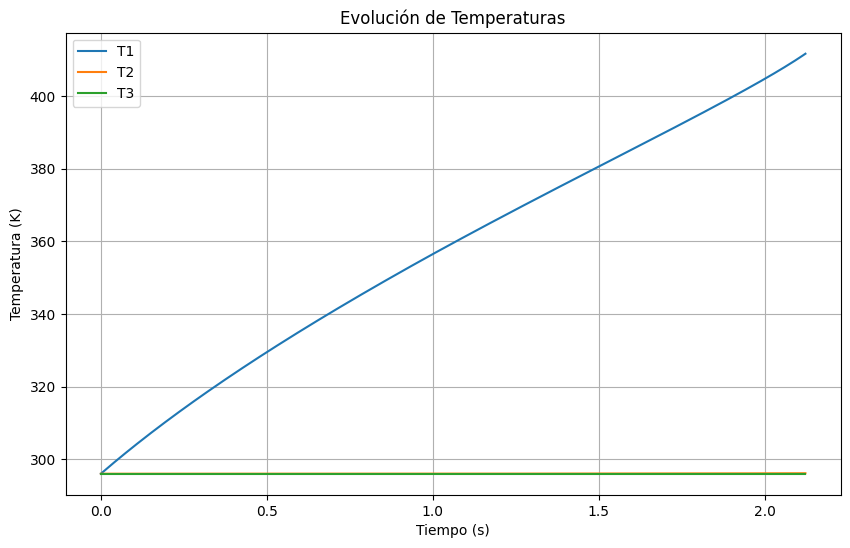

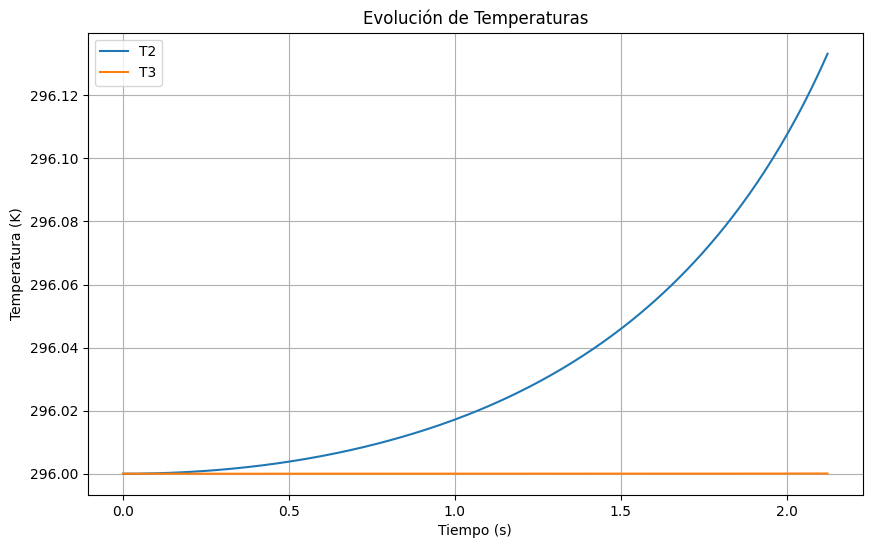

In [2]:
## Solver del modelo termico durante la combustión

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Definir la ruta del archivo de entrada
file_path = r"C:/Users/german.perez/OneDrive - Destinus NL BV/Escritorio/Personal/TFG/Fotos/6 - Resultados/t_P_T_rdot_Ab_C1_hc_Gc_GL12.txt"

# Definir la ruta de guardado del archivo de salida y las imágenes
txt_output_path = r"C:/Users/german.perez/OneDrive - Destinus NL BV/Escritorio/Personal/TFG/Fotos/6 - Resultados/Temp_1_2_3_quema.txt"
img_output_path = r"C:/Users/german.perez/OneDrive - Destinus NL BV/Escritorio/Personal/TFG/Fotos/6 - Resultados/"

# Leer los datos
columns = ['Tiempo', 'Presión_bar', 'Temperatura', 'Velocidad_recesion', 'r0', 'Ab', 'C1', 'hc', 'Gc', 'GL12']
df = pd.read_csv(file_path, sep='\s+', decimal='.', header=None, skiprows=1, names=columns, encoding='ISO-8859-1')
df = df.astype(float)

# Parámetros iniciales
r1, r2, r3 = 0.024, 0.025, 0.0265  # Radios en metros
H1 = 0.100  # Altura en metros

c_2, c_3 = 2300, 480  # J/kgK
rho2, rho3 = 1000, 7800  # kg/m³
k2 = 0.18  # w/mK
k3 = 16 # w/mK

g = 9.81  # Gravedad
ka = 0.0262  # W/mK

# Temperaturas iniciales
Tamb = 23 + 273  # K
T1_i, T2_i, T3_i = Tamb, Tamb, Tamb
Tt_i = np.array([T1_i, T2_i, T3_i])

# Conductancias térmicas actualizadas
GL2_ = (2* np.pi *k2*H1)/(np.log((2*r2)/(r1+r2)))* (2 * np.pi * H1 * r2)
GL3 = (2* np.pi *k3*H1)/(np.log((r2+r3)/(2*r2)))* (2 * np.pi * H1 * r2)
GL23 = 1 / ((1/GL2_) + (1/GL3))

# Inicialización de resultados
T1, T2, T3 = [T1_i], [T2_i], [T3_i]

# Iteración sobre los datos de entrada
for i in range(1, len(df)):
    # Obtener el paso de tiempo dinámico
    h = df.loc[i, 'Tiempo'] - df.loc[i - 1, 'Tiempo']
    
    Tc, C1, Gc, GL12 = df.loc[i, 'Temperatura'], df.loc[i, 'C1'], df.loc[i, 'Gc'], df.loc[i, 'GL12']
    
    #print(f"Iteración {i}: h={h}, C1={C1}, Gc={Gc}, GL12={GL12}")


    # Detener ejecución si C1 < 18
    if C1 < 18:
        print(f"Ejecución detenida en el índice {i} porque C1 = {C1} es menor que 18.")
        break
    
    # Capacitancia térmica actualizada
    C2 = c_2 * rho2 * np.pi * H1 * (r2**2 - r1**2)
    C3 = c_3 * rho3 * np.pi * H1 * (r3**2 - r2**2)
    
    # Calculo de Gext en cada paso
    T3_curr = T3[-1]
    RaL = ((g * 3.3e-3 * H1**3) / (2.2e-5 * 1.48e-5)) * (T3_curr - Tamb)
    hext = ((0.825 + ((0.387 * RaL**(1/6)) / ((1 + (0.492 / (1.48e-5 / 2.2e-5))**(9/16))**(8/27))))**2) * (ka / H1)
    hrad = 0.42 * 5.670374419e-8 * (T3_curr**2 + Tamb**2) * (T3_curr + Tamb)
    Gext = (hrad + hext) * (2 * np.pi * H1 * r3)
        
    print(RaL)

    # Definición de la matriz de coeficientes
    A = np.array([
        [-1 / C1 * (GL12 + Gc), 1 / C1 * GL12, 0],
        [1 / C2 * GL12, -1 / C2 * (GL12 + GL23), 1 / C2 * GL23],
        [0, 1 / C3 * GL23, -1 / C3 * (GL23 + Gext)]
    ])


    # Vector de términos independientes
    B = np.array([
        1 / C1 * Gc * Tc,
        0,
        1 / C3 * Gext * Tamb
    ])
    
    # Cálculo de temperaturas en el siguiente paso de tiempo
    T_next = (np.eye(3) + h * A) @ np.array([T1[-1], T2[-1], T3[-1]]) + h * B
    
    T1.append(T_next[0])
    T2.append(T_next[1])
    T3.append(T_next[2])

# Guardar resultados en un archivo
data_out = pd.DataFrame({'Tiempo': df['Tiempo'][:len(T1)], 'T1': T1, 'T2': T2, 'T3': T3})
data_out.to_csv(txt_output_path, sep='\t', index=False, float_format='%.6f')


# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(df['Tiempo'][:len(T1)], T1, label='T1', linestyle='-')
plt.plot(df['Tiempo'][:len(T1)], T2, label='T2', linestyle='-')
plt.plot(df['Tiempo'][:len(T1)], T3, label='T3', linestyle='-')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (K)')
plt.legend()
plt.grid()
plt.title('Evolución de Temperaturas')
plt.savefig(img_output_path + '06 - Temperaturas 1 2 y 3.png')
plt.show()

# Graficar resultados
plt.figure(figsize=(10, 6))
#plt.plot(df['Tiempo'][:len(T1)], T1, label='T1', linestyle='-')
plt.plot(df['Tiempo'][:len(T1)], T2, label='T2', linestyle='-')
plt.plot(df['Tiempo'][:len(T1)], T3, label='T3', linestyle='-')
plt.xlabel('Tiempo (s)')
plt.ylabel('Temperatura (K)')
plt.legend()
plt.grid()
plt.title('Evolución de Temperaturas')
plt.savefig(img_output_path + '06 - Temperaturas 2 y 3.png')
plt.show()